In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
import metpy.plots as mpplots

import numpy as np

from matplotlib.patheffects import withStroke
from metpy.io import parse_metar_file
from metpy.units import pandas_dataframe_to_unit_arrays
from metpy.units import units

# Here is where we import the TDSCatalog class from siphon for obtaining our data 
from siphon.catalog import TDSCatalog







In [29]:
satcat = TDSCatalog(
    "https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/CONUS/Channel02/current/catalog.xml"
)
satdata = satcat.datasets[0].remote_access(use_xarray=True)


In [30]:
print(satcat.datasets[0])
print(satdata.attrs['start_date_time'])

OR_ABI-L2-CMIPC-M6C02_G16_s20232991511170_e20232991511170_c20232991511170.nc
2023299151117


In [31]:
# extract data array with geographic information
cmi = satdata.metpy.parse_cf("Sectorized_CMI")

# extract the date and time of the most recent array
dt = datetime.strptime(satdata.attrs["start_date_time"], "%Y%j%H%M%S")
dt

datetime.datetime(2023, 10, 26, 15, 11, 17)

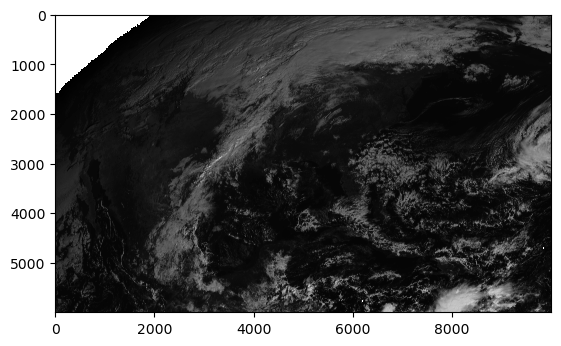

In [5]:
plt.imshow(cmi, cmap='Greys_r');

In [32]:
# Again using Siphon, get the full collection of RTMA 
# data opened using xarray.
rtma_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml')
rtma_data = rtma_cat.datasets['Full Collection (Reference / Forecast Time) Dataset'].remote_access(use_xarray=True)
rtma_data = rtma_data.metpy.parse_cf()

In [33]:
# ACTIVITY: 
# rtma_data is an xarray Dataset containing several different variables. 
# Use the space below to programmatically display the list of all
# variables in the Dataset.



## INSTRUCTOR'S ANSWER KEY ##
# Recall from day 1
# Have learner share in chat window
# without using print, errors come up accessing one specific variable before the variable list is displayed
# print(rtma_data)
rtma_data

<xarray.Dataset>
Dimensions:                                                              (
                                                                          validtime1Offset: 1,
                                                                          : 2,
                                                                          reftime1: 733,
                                                                          x: 2145,
                                                                          y: 1377,
                                                                          reftime: 734,
                                                                          timeOffset: 1,
                                                                          height_above_ground: 1,
                                                                          height_above_ground1: 1,
                                                                          altitude_above_msl: 1)
Coordinates:
  * validtime1Offset                                                     (validtime1Offset) float64 ...
  * reftime1                                                             (reftime1) datetime64[ns] ...
    validtime1                                                           (reftime1, validtime1Offset) datetime64[ns] ...
  * x                                                                    (x) float32 ...
  * y                                                                    (y) float32 ...
  * reftime                                                              (reftime) datetime64[ns] ...
  * timeOffset                                                           (timeOffset) float64 ...
    time                                                                 (reftime, timeOffset) datetime64[ns] ...
    metpy_crs                                                            object ...
  * height_above_ground                                                  (height_above_ground) float32 ...
  * height_above_ground1                                                 (height_above_ground1) float32 ...
  * altitude_above_msl                                                   (altitude_above_msl) float32 ...
Dimensions without coordinates: 
Data variables: (12/23)
    LambertConformal_Projection                                          int32 ...
    validtime1Offset_bounds                                              (validtime1Offset, ) datetime64[ns] ...
    validtime1_bounds                                                    (reftime1, validtime1Offset, ) datetime64[ns] ...
    Total_cloud_cover_Analysis_entire_atmosphere_single_layer            (reftime, timeOffset, y, x) float32 ...
    Pressure_error_surface                                               (reftime, timeOffset, y, x) float32 ...
    Wind_direction_from_which_blowing_error_height_above_ground          (reftime, timeOffset, height_above_ground, y, x) float32 ...
    ...                                                                   ...
    Wind_speed_Analysis_height_above_ground                              (reftime, timeOffset, height_above_ground, y, x) float32 ...
    u-component_of_wind_Analysis_height_above_ground                     (reftime, timeOffset, height_above_ground, y, x) float32 ...
    v-component_of_wind_Analysis_height_above_ground                     (reftime, timeOffset, height_above_ground, y, x) float32 ...
    Geopotential_height_Analysis_surface                                 (reftime, timeOffset, y, x) float32 ...
    Dewpoint_temperature_Analysis_height_above_ground                    (reftime, timeOffset, height_above_ground1, y, x) float32 ...
    Total_precipitation_Forecast_altitude_above_msl_1_Hour_Accumulation  (reftime1, validtime1Offset, altitude_above_msl, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                 

In [34]:
# From the list of variables in rtma_data, we will pull 
# "Pressure_Analysis_surface" out of the dataset for our 
# surface pressure. 
pres = rtma_data.Pressure_Analysis_surface.metpy.sel(reftime=dt, method='nearest').squeeze()
temp = rtma_data.Temperature_Analysis_height_above_ground.metpy.sel(reftime=dt, method='nearest').squeeze()
dewp = rtma_data.Dewpoint_temperature_Analysis_height_above_ground.metpy.sel(reftime=dt, method='nearest').squeeze()

# pres
# plt.imshow(dewp, origin="lower")
# temp
# dew

In [35]:
# mpcalc.equivalent_potential_temperature

In [36]:
theta_e = mpcalc.equivalent_potential_temperature(pres, temp, dewp)

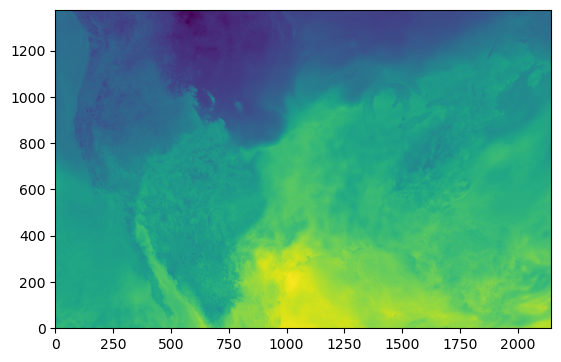

In [37]:
plt.imshow(theta_e, origin='lower')

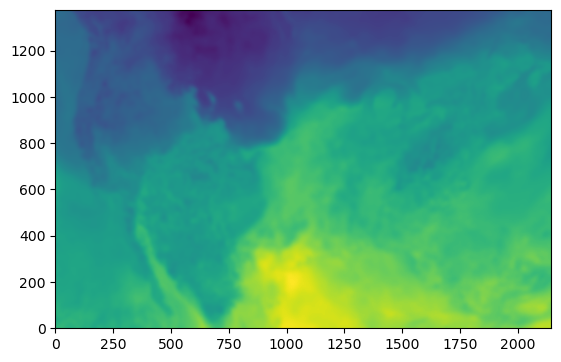

In [38]:
theta_e = mpcalc.smooth_gaussian(theta_e, n=50)
plt.imshow(theta_e, origin='lower')

In [39]:
rtma_crs = theta_e.metpy.cartopy_crs

NameError: name 'metpy' is not defined

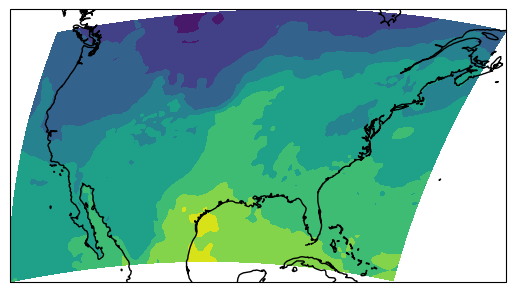

In [41]:
# Create axes, then use contourf to create filled contours of the theta_e field
ax = plt.axes(projection=ccrs.Robinson())
ax.contourf(theta_e['x'], theta_e['y'], theta_e, transform=rtma_crs)

# ACTIVITY: Plot coastlines
# What single line of code is needed to add 
# coastlines to the above plot?

## INSTRUCTOR'S ANSWER KEY ##
ax.coastlines()

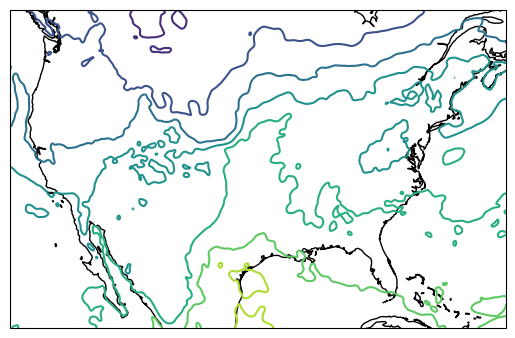

In [42]:
# ACTIVITY: Contour plot
# Our final plot will use the LambertConformal projection,
# the same projection the RTMA dataset uses. We also will
# not use filled contours, since they must be plotted 
# overtop of a satellite image. 
# 
# Re-plot the map above using the same projection as the 
# RTMA dataset, use the contour() plot type, and include 
# coastlines. 
#
# Matplotlib contour():
#    https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
#
# CHALLENGE: Single color contours
# Create the contour plot where all contours are a 
# single color of your choosing.



## INSTRUCTOR'S ANSWER KEY ##
ax = plt.axes(projection=rtma_crs)
ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e, transform=rtma_crs)
ax.coastlines()

In [43]:
ccrs.Geostationary

cartopy.crs.Geostationary

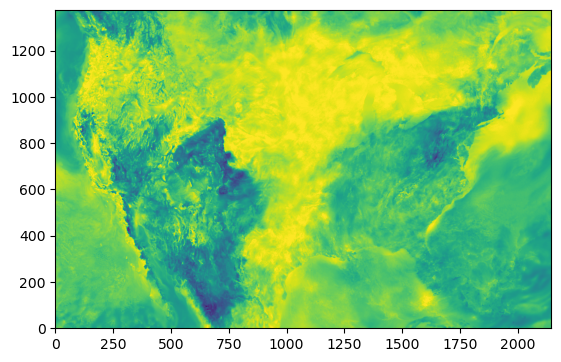

In [44]:
rh = mpcalc.relative_humidity_from_dewpoint(temp, dewp)
plt.imshow(rh, origin="lower")

# Station plot

In [45]:
metar_cat = TDSCatalog('https://thredds-test.unidata.ucar.edu/thredds/catalog/noaaport/text/metar/catalog.xml')

metar_text = metar_cat.datasets.filter_time_nearest(dt).remote_open(mode='t')


In [46]:
# parse_metar_file() outputs a pandas DataFrame
sfc_data = parse_metar_file(metar_text, year=dt.year, month=dt.month)

# Save the units for all columns to a new variable
sfc_units = sfc_data.units

# Filter out missing lat/lon data
sfc_data = sfc_data[sfc_data.latitude.notna() & sfc_data.longitude.notna()]

# Set missing weather condition data to an empty string, ''
sfc_data['current_wx1'][sfc_data['current_wx1'].isna()] = ''

In [47]:
sfc_data

,station_id,latitude,longitude,elevation,date_time,wind_direction,wind_speed,wind_gust,visibility,current_wx1,...,air_temperature,dew_point_temperature,altimeter,current_wx1_symbol,current_wx2_symbol,current_wx3_symbol,remarks,air_pressure_at_sea_level,eastward_wind,northward_wind
station_id,,,,,,,,,,,,,,,,,,,,,
K2W6,K2W6,38.32,-76.55,44.0,2023-10-26 14:49:00,210.0,8.0,NaN,16093.440,,...,18.0,13.0,30.32,0,0,0,AO1,1027.01,4.000000,6.928203e+00
PAKU,PAKU,70.31,-149.58,2.0,2023-10-26 14:45:00,150.0,11.0,NaN,16093.440,,...,-10.0,-13.0,30.18,0,0,0,,1022.34,-5.500000,9.526279e+00
K0A9,K0A9,36.36,-82.17,486.0,2023-10-26 14:45:00,100.0,5.0,NaN,9656.064,HZ,...,18.0,12.0,30.36,5,0,0,AO2,1027.62,-4.924039,8.682409e-01
KATP,KATP,27.20,-90.03,62.0,2023-10-26 14:50:00,130.0,14.0,22.0,12874.752,,...,28.0,21.0,30.08,0,0,0,A01,1018.60,-10.724622,8.999027e+00
KHUM,KHUM,29.57,-90.67,3.0,2023-10-26 14:47:00,90.0,8.0,NaN,11265.408,,...,25.0,22.0,30.11,0,0,0,,1019.93,-8.000000,-4.898587e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LTCV,LTCV,37.36,42.07,621.0,2023-10-26 15:50:00,230.0,5.0,NaN,10000.000,,...,20.0,7.0,30.09,0,0,0,,1017.56,3.830222,3.213938e+00
OMFJ,OMFJ,25.10,56.32,28.0,2023-10-26 15:50:00,220.0,3.0,NaN,6000.000,RA,...,27.0,23.0,30.00,63,0,0,A3002,1016.17,1.928363,2.298133e+00
LICF,LICF,38.20,15.55,51.0,2023-10-26 15:55:00,340.0,4.0,NaN,9999.000,,...,23.0,19.0,29.80,0,0,0,BKN QUK 2 QUL 0 VIS MAR 12 KM MON CLD SCT NC V...,1009.13,1.368081,-3.758770e+00


In [48]:
# Create final data structure
sfc_data = pandas_dataframe_to_unit_arrays(sfc_data, sfc_units)

In [49]:
# ACTIVITY: Convert wx code
# Convert weather (wx) abbreviation to WMO numeric wx code
# using the documentation linked above. 
# 
# sfc_data['wx_code'] = 



## INSTRUCTOR'S ANSWER KEY ##
sfc_data['wx_code'] = mpplots.wx_code_to_numeric(sfc_data['current_wx1'])

In [50]:
list(sfc_data)
len(sfc_data['wx_code'])

9441

In [51]:
# ACTIVITY: Calculate u and v wind
# The METAR reports wind as speed and direction, 
# but MetPy needs wind data as u and v components 
# for plotting. 
# Review the wind_components documentation and/or
# a code sample for a similar plot type, then 
# write the u wind component to sfc_data['u']
# and the v wind component to sfc_data['v']
# Documentation:
# https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_components.html
# Code sample:
# https://unidata.github.io/MetPy/latest/examples/plots/Mesonet_Stationplot.html



## INSTRUCTOR'S ANSWER KEY ##
sfc_data['u'], sfc_data['v'] = mpcalc.wind_components(sfc_data['wind_speed'], sfc_data['wind_direction'])

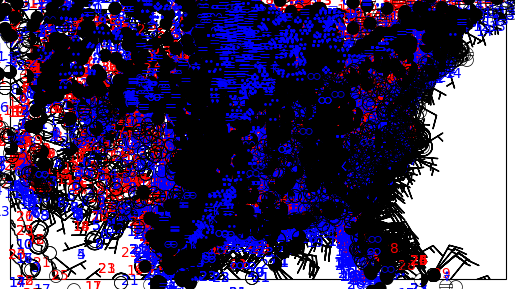

In [52]:
ax = plt.axes(projection=rtma_crs)
stn = mpplots.StationPlot(ax, sfc_data['longitude'].m, sfc_data['latitude'].m,
                         transform=ccrs.PlateCarree())
stn.plot_parameter('NW', sfc_data['air_temperature'], color='red')
stn.plot_parameter('SW', sfc_data['dew_point_temperature'], color='blue')

stn.plot_symbol('C', sfc_data['cloud_coverage'], mpplots.sky_cover)
stn.plot_symbol('E', sfc_data['wx_code'], mpplots.current_weather, color='blue')

# Populate the wind bard
stn.plot_barb(sfc_data['u'], sfc_data['v'])

# Add coastlines and set extent to the Southeast US
ax.coastlines()
ax.set_extent((-113, -70, 25, 45))







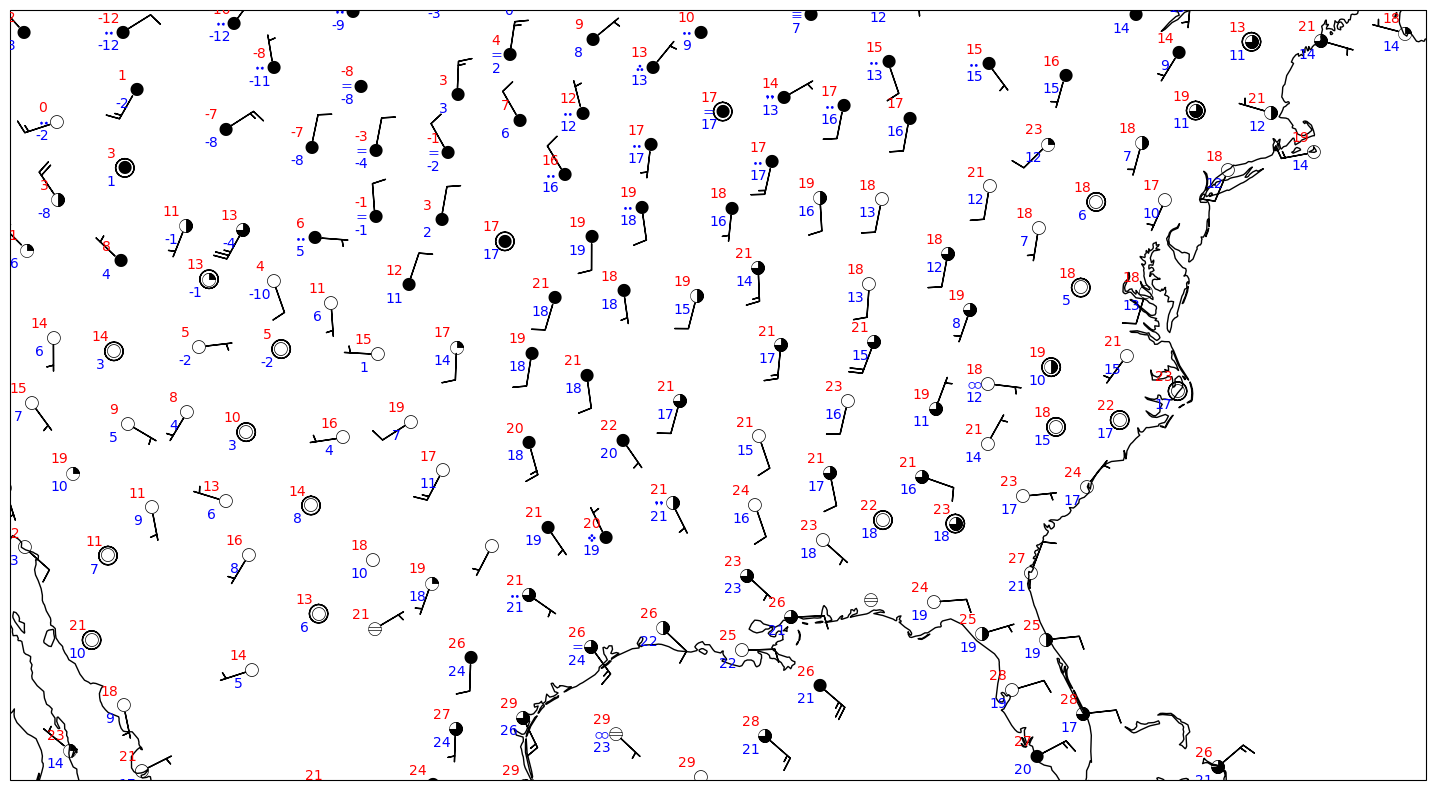

In [53]:
# Create an array of station locations
locs = rtma_crs.transform_points(ccrs.PlateCarree(), 
                                 sfc_data['longitude'].m, sfc_data['latitude'].m)

# Create the 1:175 km plot mask
plot_mask = mpcalc.reduce_point_density(locs[..., :2], 175000)

# Increase the size of the plot on the screen
fig = plt.figure(figsize=(20, 10))

# Create matplotlib axes in the Plate Carree projection
ax = fig.add_subplot(projection=rtma_crs)

# Create the StationPlot class with the plot_mask applied 
# (append [plot_mask] to the end of each variable)
stn = mpplots.StationPlot(ax, sfc_data['longitude'][plot_mask].m, 
                          sfc_data['latitude'][plot_mask].m, 
                          transform=ccrs.PlateCarree(), 
                          clip_on=True)

# ACTIVITY: Apply plot_mask
# Populate all variables as previous, but apply the plot_mask
# this time. The temperature field is completed for you. 
# Continue with dewpoint, cloud coverage, wx_code, and the 
# wind barb.
stn.plot_parameter('NW', sfc_data['air_temperature'][plot_mask], color='red')

## INSTRUCTOR'S ANSWER KEY ##
stn.plot_parameter('SW', sfc_data['dew_point_temperature'][plot_mask], color='blue')
stn.plot_symbol('C', sfc_data['cloud_coverage'][plot_mask], mpplots.sky_cover)
stn.plot_symbol('W', sfc_data['wx_code'][plot_mask], mpplots.current_weather, color='blue')
stn.plot_barb(sfc_data['u'][plot_mask], sfc_data['v'][plot_mask])

# Finishing touches
ax.coastlines()
ax.set_extent((-113, -70, 25, 45))


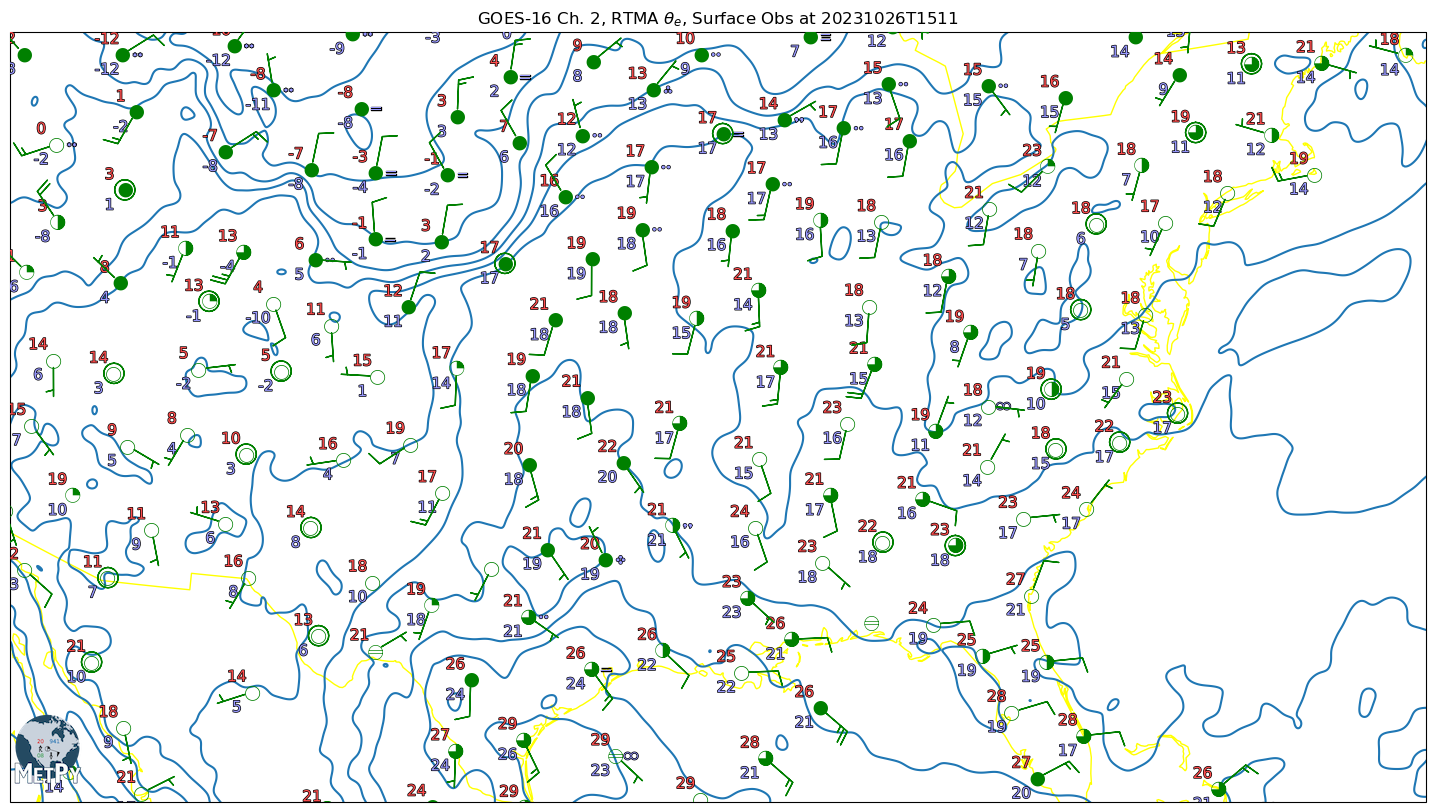

In [97]:
# Create axes
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=rtma_crs)

# Plot satellite image:
# regrid_shape controls the detail of the reprojection 
# of the satellite data; a smaller number indicates 
# faster plotting at the expense of detail. 
# Start with 500 to get a general sense of the data, 
# and increase to ~6000 for better quality plots. 
image_extent = (cmi.metpy.x[0], cmi.metpy.x[-1], cmi.metpy.y[0], cmi.metpy.y[-1])

# ax.imshow(cmi, extent=image_extent, origin='lower', cmap='Greys_r',
#           regrid_shape=20, transform=cmi.metpy.cartopy_crs)

# Plot theta_e as contours:
ax.contour(theta_e.metpy.x, theta_e.metpy.y, theta_e,
           levels=range(240, 400, 8), colors='tab:blue', 
           transform=theta_e.metpy.cartopy_crs)

# Plot surface observations as a station plot:
# Here we are also adding several readability modifications.
#     path_effects - used to draw the text with a thin 
#                    outline to help it show up better.
#     RGB colors   - used to lighten up the default red  
#                    and blue to make text stand out.
stn = mpplots.StationPlot(ax, sfc_data['longitude'][plot_mask].m, sfc_data['latitude'][plot_mask].m,
                          transform=ccrs.PlateCarree(), fontsize=11, zorder=10, clip_on=True)
stn.plot_parameter('NW', sfc_data['air_temperature'][plot_mask], color=[1.0,0.3,0.3],
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_parameter('SW', sfc_data['dew_point_temperature'][plot_mask], color=[0.6,0.6,1.0],
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_symbol('C', sfc_data['cloud_coverage'][plot_mask], mpplots.sky_cover, color='g')
stn.plot_symbol('E', sfc_data['wx_code'][plot_mask], mpplots.current_weather, color=[0.6,0.6,1.0],
                   path_effects=[withStroke(linewidth=1, foreground='black')])
stn.plot_barb(sfc_data['u'][plot_mask], sfc_data['v'][plot_mask], color='g')

# Finishing touches, including logo and title
ax.add_feature(cfeature.BORDERS, color='yellow')
ax.add_feature(cfeature.COASTLINE, color='yellow')
ax.set_extent((-113, -70, 25, 45))
ax.set_title(r'GOES-16 Ch. 2, RTMA $\theta_e$, Surface Obs at {:%Y%m%dT%H%M}'.format(dt))
mpplots.add_metpy_logo(fig)

In [88]:
# print(image_extent)
# list(image_extent)
cmi.metpy.cartopy_crs

<Derived Projected CRS: +proj=geos +a=6378137.0 +b=6356752.31414 +lon_0=-7 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Geostationary Satellite (Sweep X)
Datum: unknown
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich